In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from torchvision import transforms
import pickle

from models import FarSegNet, DLinkNet34, LinkNet34, FarSegNet
import tester
import utils
import loss
import data_loader

In [2]:
# root_path = 'D://Data/massachusetts-roads-dataset/'
root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'
road_path = root_path + "tiff_select3_parts_16/"
DIR_CHECKPOINT = 'checkpoints/'
TEST_SAVE_PATH = '/home/renyan/road-extraction/predict_result/'
FOCAL_Z = 1
FOCAL_FACTOR = 2
FIG_SAVE_PATH = 'predict_result/mid_report/'

In [3]:
INPUT_SIZE, OUTPUT_SIZE = 256, 256
# test_dataset = data_loader.RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, data_class = 'test')

In [4]:
def plt_improve(p):
    p.xticks([])
    p.yticks([])

In [101]:
name = "11128870_15_h1_w2"
img = cv2.imread(road_path + "test/{}.tiff".format(name))
lbl = cv2.imread(road_path + "test_labels/{}.tif".format(name))

transform_data = transforms.Compose([transforms.Resize([INPUT_SIZE, INPUT_SIZE], 0), transforms.ToTensor(),])
transform_label = transforms.Compose([transforms.Resize([OUTPUT_SIZE, OUTPUT_SIZE], 0), transforms.ToTensor(),])
img_tensor, lbl_tensor = transform_data(Image.fromarray(img)).unsqueeze(0), transform_label(Image.fromarray(lbl))[:1,:,:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor, lbl_tensor = img_tensor.to(device), torch.cat([lbl_tensor.to(device)]*3)

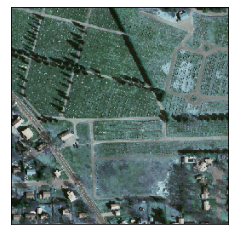

In [102]:
plt.imshow(img_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'img_7.png', bbox_inches='tight')

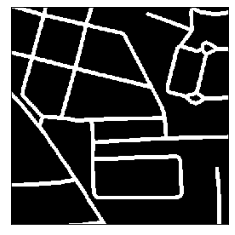

In [103]:
plt.imshow(lbl_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'lbl_7.png', bbox_inches='tight')

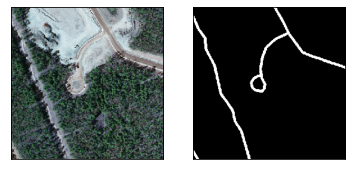

In [60]:
plt.subplot(1, 2, 1)
plt.imshow(img_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
plt_improve(plt)
plt.subplot(1, 2, 2)
plt.imshow(lbl_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
plt_improve(plt)
# plt.savefig("")

## LinkNet

In [71]:
with open('pickle_objects/tt_linknet.pickle', 'rb') as f:  
    tt_linknet = pickle.load(f)

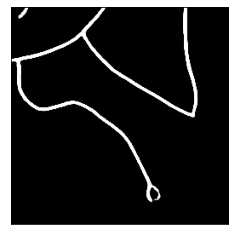

In [80]:
probs = tt_linknet.net(img_tensor).squeeze()
plt.imshow(utils.change_tensor_to_plot(probs.detach().cpu()))
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'pred_7_ln.png', bbox_inches='tight')

In [32]:
probs_list = probs.flatten().detach().cpu().numpy().tolist()

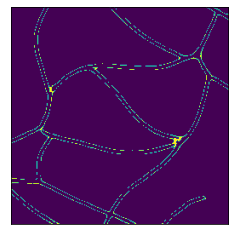

In [33]:
mask = ((probs > 0.01 ) & (probs < 0.99)).float()
plt.imshow(mask.detach().cpu())
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'prob_6_ln.png', bbox_inches='tight')

## D-LinkNet

In [73]:
with open('pickle_objects/tt_dlinknet.pickle', 'rb') as f:  
    tt_dlinknet = pickle.load(f)

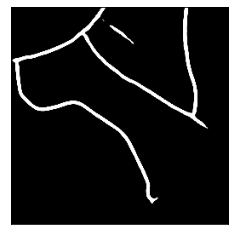

In [81]:
probs = tt_dlinknet.net(img_tensor).squeeze()
plt.imshow(utils.change_tensor_to_plot(probs.detach().cpu()))
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'pred_7_dn.png', bbox_inches='tight')

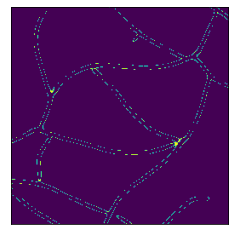

In [36]:
mask = ((probs > 0.05 ) & (probs < 0.95)).float()
plt.imshow(mask.detach().cpu())
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'prob_6_dn.png', bbox_inches='tight')

## FarSeg

In [82]:
with open('pickle_objects/tt_farseg.pickle', 'rb') as f:  
    tt_farseg = pickle.load(f)

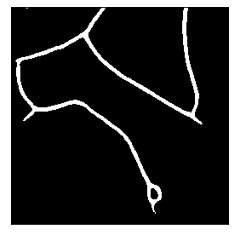

In [84]:
# 预测结果
# lbl_tensor = lbl_tensor[0,:,:]
probs, preds = tt_farseg.net(img_tensor)

plt.imshow(utils.change_tensor_to_plot(preds.float().squeeze().cpu().detach().numpy()))
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'pred_7_fs.png', bbox_inches='tight')

In [85]:
# p 判断为该类的概率
p = ((1-lbl_tensor) + (-1)**(1+lbl_tensor)*probs)
z = torch.pow(1.0 - p, FOCAL_FACTOR)
z = FOCAL_Z * z

In [86]:
z[0,0,:,:].shape

torch.Size([256, 256])

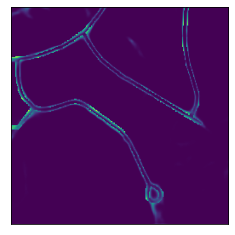

In [87]:
# 难易程度
plt.imshow(z[0,0,:,:].cpu().detach().numpy())
plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'prob_6_fs.png', bbox_inches='tight')

In [186]:
# # 对该像素点预测的把握程度
# plt.imshow(p.squeeze().cpu().detach().numpy())

In [271]:
# 该像素点是道路的概率
# plt.imshow(probs.squeeze().cpu().detach().numpy())
# plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'probr_3_fs.png', bbox_inches='tight')

## D-FarSeg

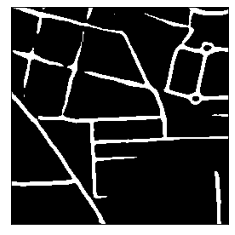

In [104]:
net = FarSegNet.FarSegNet()
net.load_state_dict(torch.load('checkpoints/v3_farseg_epoch50.pth'))
net.eval()
net = net.to(device)

probs, preds = net(img_tensor)

plt.imshow(utils.change_tensor_to_plot(preds.float().squeeze().cpu().detach().numpy()))
plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'pred_6_fd.png', bbox_inches='tight')

In [105]:
# p 判断为该类的概率
p = ((1-lbl_tensor) + (-1)**(1+lbl_tensor)*probs)
z = torch.pow(1.0 - p, FOCAL_FACTOR)
z = FOCAL_Z * z

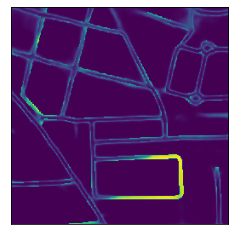

In [107]:
# 难易程度
plt.imshow(z[0,0,:,:].cpu().detach().numpy())
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'prob_3_fd.png', bbox_inches='tight')

## Layer Heatmap

- c
- p
- z

In [272]:
net = tt_farseg.net

In [276]:
c2 = net.backbone_layer_c2(img_tensor)
c2.shape

torch.Size([1, 256, 64, 64])

## Hard Example Estimation

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = FarSegNet.FarSegNet().to(device)
net.eval()
choices = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
choices = [1, 100]
z_list = []
for choice in choices:
    checkpoint_str = 'v2_farseg_epoch{}.pth'.format(choice)
    print("==========================={}===============================".format(checkpoint_str))
    net.load_state_dict(torch.load('checkpoints/' + checkpoint_str))
    probs, preds = net(img_tensor, lbl_tensor[:1,:,:])
    print(probs.shape)
    p = ((1-lbl_tensor) + (-1)**(1+lbl_tensor)*probs)
    z = torch.pow(1.0 - p, FOCAL_FACTOR)
    z = FOCAL_Z * z
    z_list.append(z.squeeze()[0,:,:].detach().cpu().numpy())

===========================v2_farseg_epoch1.pth===============================
torch.Size([1, 1, 256, 256])
===========================v2_farseg_epoch100.pth===============================
torch.Size([1, 1, 256, 256])


In [23]:
z_list[0].shape

(256, 256)

In [28]:
# z = z_list[0]
# plt.figure()
# plt.imshow(z)
# plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'prob_3_fs_epoch1.png', bbox_inches='tight')

In [29]:
# z = z_list[1]
# plt.figure()
# plt.imshow(z)
# plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'prob_3_fs_epoch100.png', bbox_inches='tight')